In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import scipy
from scipy.optimize import minimize
import networkx as nx

In [2]:
def show(img):
    cv2.imshow("title",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
class Gaussian:
    def __init__(self, mean=np.zeros((3,1)), sigma=np.eye(3)):
        self.mean = np.array(mean)
        self.sigma = np.array(sigma)

    def compute_probability(self, x):
        return scipy.stats.multivariate_normal.pdf(np.array(x),mean=self.mean,cov=self.sigma)

    def update_parameters(self, data):
        self.mean = np.mean(data, axis=0)
        self.sigma = np.cov(data, rowvar=0)
        
    def set_parameter(self,mean,sigma):
        self.mean = np.array(mean)
        self.sigma = np.array(sigma)

In [4]:
class GMM:
    def __init__(self, K):
        self.K = K
        self.gaussians = [Gaussian() for _ in range(self.K)]
        self.weights = np.array([1.0/K]*K)

    def initialize_gmm(self, X):
        clusterer = KMeans(n_clusters=self.K, max_iter=10, random_state=None)
        clusters = clusterer.fit_predict(X)

        num_pixels = float(X.shape[0])
        
        for i, gaussian in enumerate(self.gaussians):
            gaussian.update_parameters(X[clusters==i])
            self.weights[i] = np.sum(clusters==i)/num_pixels
            
        return clusters

    def get_component(self, x):
        components = np.zeros((x.shape[0], len(self.gaussians)))

        for i,g in enumerate(self.gaussians):
            components[:, i] = self.weights[i]*g.compute_probability(x)
    
        return np.argmax(components, axis=1)

    def compute_probability(self, x):
        return np.dot(self.weights, [g.compute_probability(x) for g in self.gaussians])
    
    def update_gmm(self, X, means, sigmas, weight):
        num_pixels = X.shape[0]
        
        for i,gaussian in enumerate(self.gaussians):
            gaussian.set_parameter(means[i],sigmas[i])
            
#         temp1 = np.zeros((num_pixels,5))
#         temp2 = np.zeros((num_pixels))
#         temp_weight = np.zeros(5)
#         for i in range(5):
#             temp1[:,i] = FG_GMM.gaussians[i].compute_probability(X)
#         for i in range(num_pixels):
#             temp2[i] = np.argmax(temp1[i])
#         for i in range(5):
#             temp_weight[i] = np.sum(temp2==i) / num_pixels

        self.weights = weight

In [59]:
img = cv2.imread("image1.jpg")

xmin, ymin, xmax, ymax = 130,40,500,440
height, width, _ = img.shape
alpha = np.zeros((height, width), dtype=np.int8)

for h in range(height):
    for w in range(width):
        if (w >= xmin) and (w <= xmax) and (h >= ymin) and (h <= ymax):
            alpha[h,w] = 1

In [81]:
img12312 = cv2.imread("image1.jpg",0)
mask = np.full_like(img12312,1.0,dtype=np.float32)
mask[ymin:ymax,xmin:xmax] = 0

show(mask)

In [61]:
fore_ground = img[alpha == 1]
back_ground = img[alpha == 0]

FG_GMM = GMM(5)
BG_GMM = GMM(5)

In [62]:
FG_cluster = FG_GMM.initialize_gmm(fore_ground)
BG_cluster = BG_GMM.initialize_gmm(back_ground)

In [63]:
pixels = img.reshape((img.shape[0]*img.shape[1], img.shape[2]))

In [64]:
f_component_map = (FG_GMM.get_component(pixels).reshape((img.shape[0],img.shape[1])) ) *0.25
b_component_map = (BG_GMM.get_component(pixels).reshape((img.shape[0],img.shape[1])) ) *0.25

In [65]:
h1, w1 = f_component_map.shape[:2]
h2, w2 = b_component_map.shape[:2]
vis = np.zeros((max(h1, h2), w1+w2), np.float32)
vis[:h1, :w1] = f_component_map
vis[:h2, w1:w1+w2] = b_component_map
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

show(vis)

In [66]:
k = np.ones((img.shape[0],img.shape[1]), dtype=np.float32)*-1
k[alpha==1] = f_component_map[alpha==1]
k[alpha==0] = b_component_map[alpha==0]
show(k)

### --------------------------------GMM 끝--------------------------------------------
### --------------------------------energy 시작--------------------------------------------

In [13]:
def cofactor_matrix(matrix):
    return np.linalg.inv(matrix).T * np.linalg.det(matrix)

def weight_plus(w_list,w):
    w_list.append(w)
    
def a_plus(a):
    a.append(True)

In [79]:
mean_list[f_comp_map]

array([[[167.81357172, 186.49947176, 201.98939456]],

       [[167.81357172, 186.49947176, 201.98939456]],

       [[167.81357172, 186.49947176, 201.98939456]],

       ...,

       [[110.5823832 , 141.98528936, 152.06639571]],

       [[110.5823832 , 141.98528936, 152.06639571]],

       [[110.5823832 , 141.98528936, 152.06639571]]])

In [17]:
def data_term_v2(x0,img,k):
    weight_list = np.reshape(x0[:5],(5))
    mean_list = np.reshape(x0[5:20],(5,3))
    sigma_list = np.reshape(x0[20:],(5,3,3))
    
    pixels = img.reshape((img.shape[0]*img.shape[1], img.shape[2]))
    
    pi_base = weight_list
    pi = pi_base[k].reshape(pixels.shape[0])
    
    dets_base = np.array([np.linalg.det(sigma_list[i]) for i in range(5)])
    dets = dets_base[k].reshape(pixels.shape[0])

    means_base = np.array([mean_list[i] for i in range(5)])
    means = np.swapaxes(means_base[k], 1, 2)
    means = means.reshape((means.shape[0:2]))

    cov_base = np.array([np.linalg.inv(sigma_list[i]) for i in range(5)])
    cov = np.swapaxes(cov_base[k], 1, 3)
    cov = cov.reshape((cov.shape[0:3]))

    distances = []
    residual = pixels - means
    for i in range(residual.shape[0]):
        distance = scipy.spatial.distance.mahalanobis(residual[i], [0,0,0], cov[i])
        distances.append(distance)
        
    maha_dist = np.array(distances)
    
    print((-np.log(pi) + 0.5 * np.log(dets) + 0.5 * maha_dist).sum())
    return (-np.log(pi + 1e-7) + 0.5 * np.log(dets + 1e-7) + 0.5 * maha_dist).sum()

In [67]:
def data_term_v1(x0,img,gmm,a,www):
    a_plus(a)
    a = len(a)
    weight_list = np.reshape(x0[:5],(5))
    mean_list = np.reshape(x0[5:20],(5,3))
    sigma_list = np.reshape(x0[20:],(5,3,3))
    weight_plus(www,x0)
    pixels = img.reshape((img.shape[0]*img.shape[1], img.shape[2]))
    k = gmm.get_component(pixels).reshape((pixels.shape[0], 1))
    
    gmm.update_gmm(img,mean_list,sigma_list,weight_list)
    if a % 10 == 0 :
        cv2.imwrite("tmp4/tmp{}.jpg".format((int(a/10))),(gmm.get_component(pixels).reshape((img.shape[0],img.shape[1])))*63.75)
        print("{} 번째 이미지 출력했음!".format(int(a/10)))
    
    
    pi_base = weight_list
    pi = pi_base[k].reshape(pixels.shape[0])
    
    dets_base = np.array([np.linalg.det(sigma_list[i]) for i in range(5)])
    dets = dets_base[k].reshape(pixels.shape[0])

    means_base = np.array([mean_list[i] for i in range(5)])
    means = np.swapaxes(means_base[k], 1, 2)
    means = means.reshape((means.shape[0:2]))

    cov_base = np.array([np.linalg.inv(sigma_list[i]) for i in range(5)])
    cov = np.swapaxes(cov_base[k], 1, 3)
    cov = cov.reshape((cov.shape[0:3]))

    distances = []
    residual = pixels - means
    for i in range(residual.shape[0]):
        distance = scipy.spatial.distance.mahalanobis(residual[i], [0,0,0], cov[i])
        distances.append(distance)
        
    maha_dist = np.array(distances)
    
    print((-np.log(pi) + 0.5 * np.log(dets) + 0.5 * maha_dist).sum())
    return (-np.log(pi) + 0.5 * np.log(dets) + 0.5 * maha_dist).sum()

In [68]:
def jacobi(x0):
    weight_list = np.reshape(x0[:5],(5))
    mean_list = np.reshape(x0[5:20],(5,3))
    sigma_list = np.reshape(x0[20:],(5,3,3))
    inv_sig_list = np.linalg.inv(sigma_list)
    
    mean_der = []
    for i in range(5):
        mean_der.append(np.matmul(inv_sig_list[i], mean_list[i]))
    
    sigma_der1 = []
    for i in range(5):
        sigma_der1.append(1/2 * (cofactor_matrix(sigma_list[i])) * (1/np.linalg.det(sigma_list[i])))
    sigma_der1 = np.array(sigma_der1)
    
    sigma_der2 = []
    for i in range(5):
        tmp_m = (mean_list[i][np.newaxis])
        sigma_der2.append(1/2 * np.matmul(np.matmul(-inv_sig_list[i], np.matmul(tmp_m.T,tmp_m)), inv_sig_list[i]))
    sigma_der2 = np.array(sigma_der2)
    
    weight_der = np.ndarray.flatten(-1/weight_list)
    mean_der = np.ndarray.flatten(np.array(mean_der))
    sigma_der = np.ndarray.flatten(sigma_der1 + sigma_der2)

    total_der = np.concatenate((weight_der,mean_der,sigma_der))
    
    return total_der

In [69]:
jacobi(total_list)

array([-4.06056553e+00, -3.89442685e+00, -6.04514425e+00, -6.91347182e+00,
       -5.35089739e+00, -1.77101984e-01,  3.37081606e-01,  6.61141087e-01,
       -5.68249722e-01,  1.59408390e-01,  2.95375591e+00, -9.92756578e-02,
        5.48444743e-01,  6.82549077e-01, -4.11252684e-02,  2.00453277e-02,
        2.05082370e-01,  1.11674836e-01,  4.53653998e-01,  2.49502330e-01,
       -1.17521176e-02,  3.13556152e-02,  5.42428474e-02,  3.13556152e-02,
       -5.11863995e-02, -1.16415741e-01,  5.42428474e-02, -1.16415741e-01,
       -2.08305401e-01, -1.45492855e-01,  2.19812381e-02,  8.45885000e-01,
        2.19812381e-02,  4.23397834e-02, -2.66511908e-01,  8.45885000e-01,
       -2.66511908e-01, -4.33260901e+00, -8.06759630e-04,  2.27581412e-02,
        3.43337328e-02,  2.27581412e-02, -1.38721396e-01, -1.92881841e-01,
        3.43337328e-02, -1.92881841e-01, -2.26350198e-01,  3.53071136e-03,
        1.61912553e-03,  1.34104222e-03,  1.61912553e-03,  5.78069792e-03,
       -8.64302231e-03,  

In [21]:
weight_list = FG_GMM.weights
mean_list = []
sigma_list = []

for i in range(len(FG_GMM.gaussians)):
    mean_list.append(FG_GMM.gaussians[i].mean)
    sigma_list.append(FG_GMM.gaussians[i].sigma)
    
mean_list = np.ndarray.flatten(np.array(mean_list))
sigma_list = np.ndarray.flatten(np.array(sigma_list))
total_list = np.concatenate((weight_list,mean_list,sigma_list))

weight_list = np.reshape(total_list[:5],(5))
mean_list = np.reshape(total_list[5:20],(5,3))
sigma_list = np.reshape(total_list[20:],(5,3,3))

In [70]:
a = []
www = []
f_comp_map = FG_GMM.get_component(pixels).reshape((pixels.shape[0], 1))
minimize(fun = data_term_v1,x0 = total_list,args=(img,FG_GMM,a,www),method='BFGS',jac=callable(jacobi(total_list)))

3189575.8576554307
2575378.017081299
2575378.0203205626
2575378.020105066
2575378.015035156
2575378.0191198513
2575378.0225093113
2575378.0224988433
2575378.0225034505
1 번째 이미지 출력했음!
2575378.0225031925
2575378.0225081365
2575378.022497166
2575378.022502604
2575378.0225047097
2575378.022503125
2575378.022506168
2575378.0224945424
2575378.022507144
2575378.0225067874
2 번째 이미지 출력했음!
2575378.0225004475
2575378.02250481
2575378.0225078086
2575378.022505126
2575378.0224993993
2575378.022505126
2575378.022509221
2575378.022498746
2575378.0224993993
2575378.022498746
3 번째 이미지 출력했음!
2575378.0225137696
2575378.0225109295
2575378.0224928567
2575378.0225070002
2575378.0224928567
2575378.022528817
2575378.0224895873
2575378.0225070002
2575378.0224895873
2575378.0225168364
4 번째 이미지 출력했음!
2575378.02250495
2575378.022502274
2575378.022503927
2575378.022502274
2575378.0225072303
2575378.0225019595
2575378.022503927
2575378.0225019595
2575378.0225056526
2575378.0225073216
5 번째 이미지 출력했음!
2575378.02250457

KeyboardInterrupt: 

In [31]:
len(www)

153

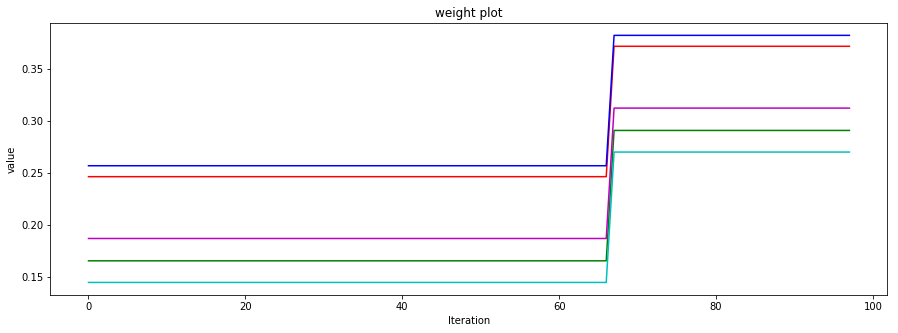

1.6263754136023811


In [71]:
w1 = []
w2 = []
w3 = []
w4 = []
w5 = []
count = len(www)
for i in range(count):
    w1.append(www[i][0])
    w2.append(www[i][1])
    w3.append(www[i][2])
    w4.append(www[i][3])
    w5.append(www[i][4])
    
    
t = np.arange(0, count, 1)
plt.rcParams["figure.figsize"] = (15,5)
plt.title("weight plot")
plt.xlabel('Iteration')
plt.ylabel('value')
plt.plot(t, w1, 'r', t, w2, 'b', t, w3, 'g', t, w4, 'c',t, w5, 'm')
plt.show()
print(w1[count-1] + w2[count-1] + w3[count-1] + w4[count-1] + w5[count-1])

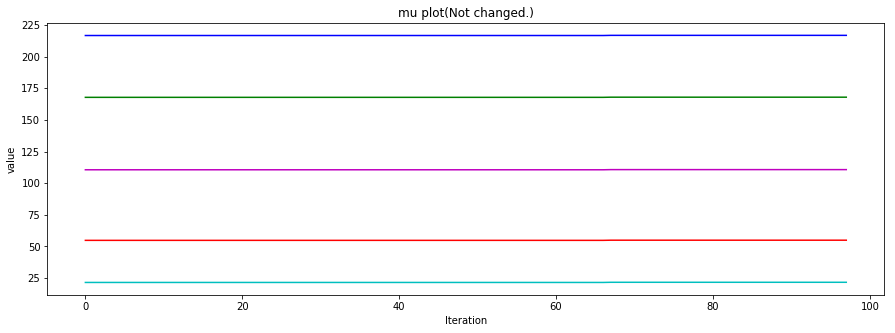

572.0691238430637


In [72]:
mu1 = []
mu2 = []
mu3 = []
mu4 = []
mu5 = []
count = len(www)
for i in range(count):
    sum_mu = np.reshape(www[i][5:20],(5,3))
    
    mu1.append(sum_mu[0][0])
    mu2.append(sum_mu[1][0])
    mu3.append(sum_mu[2][0])
    mu4.append(sum_mu[3][0])
    mu5.append(sum_mu[4][0])
    
t = np.arange(0, count, 1)
plt.rcParams["figure.figsize"] = (15,5)
plt.title("mu plot(Not changed.)")
plt.xlabel('Iteration')
plt.ylabel('value')
plt.plot(t, mu1, 'r', t, mu2, 'b', t, mu3, 'g', t, mu4, 'c',t, mu5, 'm')
plt.show()
print(mu1[count-1] + mu2[count-1] + mu3[count-1] + mu4[count-1] + mu5[count-1])

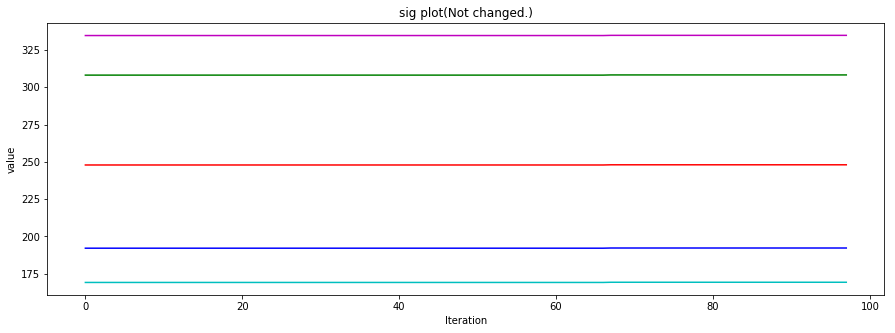

1252.4623430330253


In [73]:
sig1 = []
sig2 = []
sig3 = []
sig4 = []
sig5 = []
count = len(www)
for i in range(count):
    sum_sig = np.reshape(www[i][20:65],(5,3,3))
    
    sig1.append(sum_sig[0][0][0])
    sig2.append(sum_sig[1][0][0])
    sig3.append(sum_sig[2][0][0])
    sig4.append(sum_sig[3][0][0])
    sig5.append(sum_sig[4][0][0])
    
t = np.arange(0, count, 1)
plt.rcParams["figure.figsize"] = (15,5)
plt.title("sig plot(Not changed.)")
plt.xlabel('Iteration')
plt.ylabel('value')
plt.plot(t, sig1, 'r', t, sig2, 'b', t, sig3, 'g', t, sig4, 'c',t, sig5, 'm')
plt.show()
print(sig1[count-1] + sig2[count-1] + sig3[count-1] + sig4[count-1] + sig5[count-1])

In [16]:
U = data_term_v1(total_list,img,FG_GMM)
U.sum()

[216.66753638 227.03887554 243.63019285]
[216.44204439 229.0680946  240.76978529]
2541420.331766584


2541420.331766584

In [ ]:
def compute_beta(img):
    beta = 0
    img = np.array(img,dtype = np.float32)
    
    e_diff = img - np.roll(img, 1, axis=0)
    temp = np.sum(np.multiply(vert_diff, vert_diff), axis=2)
    beta = np.sum(temp[1:,:])

    s_diff = img - np.roll(img, 1, axis=1)
    temp = np.sum(np.multiply(horiz_diff, horiz_diff), axis=2)
    beta += np.sum(temp[:,1:])
    
    se_diff = img - np.roll(np.roll(img, 1, axis=0),1,axis = 1)
    temp = np.sum(np.multiply(se_diff, se_diff), axis=2)
    beta += np.sum(temp[1:,1:])
    
    sw_diff = img - np.roll(np.roll(img, 1, axis=0),-1,axis = 1)
    temp = np.sum(np.multiply(sw_diff, sw_diff), axis=2)
    beta += np.sum(temp[1:,:img.shape[-1]-1])
    
    num_pixel = img.shape[0] * img.shape[1]
    
    beta = 1.0/(2*(beta/num_pixel))

    return beta

In [ ]:
e_diff = img - np.roll(img, 1, axis=0)
s_diff = img - np.roll(img, 1, axis=1)
se_diff = img - np.roll(np.roll(img, 1, axis=0),1,axis = 1)
sw_diff = img - np.roll(np.roll(img, 1, axis=0),-1,axis = 1)

show(np.multiply(e_diff, e_diff) + np.multiply(s_diff, s_diff) + np.multiply(se_diff, se_diff) + np.multiply(sw_diff, sw_diff))

In [ ]:
compute_beta(img)

In [ ]:
def smoothness_term(img,alpha):
    img = np.array(img,dtype = np.float32)
    
    diff = 0
    beta = compute_beta(img)
    
    for h in range(img.shape[0]):
        for w in range(img.shape[1]):
            if h-1 >= 0 and w-1 >= 0:
                if alpha[h,w] != alpha[h-1,w-1]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h-1,w-1])
                    diff += np.exp(eucl * (-beta))
            if h-1 >= 0:
                if alpha[h,w] != alpha[h-1,w]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h-1,w])
                    diff += np.exp(eucl * (-beta)) 
            if h-1 >= 0 and w+1<img.shape[1]:
                if alpha[h,w] != alpha[h-1,w+1]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h-1,w+1])
                    diff += np.exp(eucl * (-beta))
            if w-1 >= 0:
                if alpha[h,w] != alpha[h,w-1]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h,w-1])
                    diff += np.exp(eucl * (-beta))
            if w+1<img.shape[1]:
                if alpha[h,w] != alpha[h,w+1]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h,w+1])
                    diff += np.exp(eucl * (-beta)) 
            if h+1<img.shape[0] and w-1 >= 0:
                if alpha[h,w] != alpha[h+1,w-1]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h+1,w-1])
                    diff += np.exp(eucl * (-beta)) 
            if h+1<img.shape[0]:
                if alpha[h,w] != alpha[h+1,w]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h+1,w])
                    diff += np.exp(eucl * (-beta))   
            if h+1<img.shape[0] and w+1<img.shape[1]:        
                if alpha[h,w] != alpha[h+1,w+1]:
                    eucl = scipy.spatial.distance.euclidean(img[h,w],img[h+1,w+1])
                    diff += np.exp(eucl * (-beta))

    return 50 * diff

In [ ]:
smoothness_term(img,alpha)

In [ ]:
def gibbs(img,alpha,fg_gmm,bg_gmm):
    return data_term(img,fg_gmm) + data_term(img,bg_gmm) + smoothness_term(img,alpha)

In [ ]:
gibbs1 = gibbs(img,alpha,FG_GMM,BG_GMM)
gibbs1

In [ ]:
alpha2 = alpha.copy()